In [17]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from plotnine import ggplot, aes, geom_point, geom_line, labs, theme_classic, scale_x_continuous, scale_y_continuous

house = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB544MACHINE/Week7/data/AmesHousing.csv")

# Part 1 : Ridge Regression

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with lamda = 1.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [38]:
# Get rid of columns with mostly NaN values
good_cols = house.isna().sum() < 100
house = house.loc[:,good_cols]

# Drop other NAs
house = house.dropna()

X = house.drop(["SalePrice", "Order", "PID"], axis = 1)
y = house['SalePrice']


# Notice we now have some new parameters in our ct: 
# in dummify we add the input handle_unknown='ignore - this causes errors to be dropped if encountered'
# in make_column_selectors we add (dtype_include=object) and (dtype_include=np.number)) - this causes 
# ct to only dummify objects and standardize numerical values'''
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

# make standard ols pipeline
lr_pipeline_ols = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

# make ridge regression pipeline with lambda = 1
lr_pipeline_ridge = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha= 1))]
)

# Use Cross validation on two pipelines
ridge_cv_scores = cross_val_score(lr_pipeline_ridge, X, y, cv=5, scoring='neg_mean_squared_error')
ols_cv_scores = cross_val_score(lr_pipeline_ols, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Ridge Regression MSE: {-ridge_cv_scores.mean():,.2f}')
print(f'Ordinary Linear Regression MSE: {-ols_cv_scores.mean():,.2f}')

Ridge Regression MSE: 878,606,253.14
Ordinary Linear Regression MSE: 41,126,694,068,953,769,253,475,480,240,128.00


So here we see that the ridge regression fits the model much better than the OLS model. 

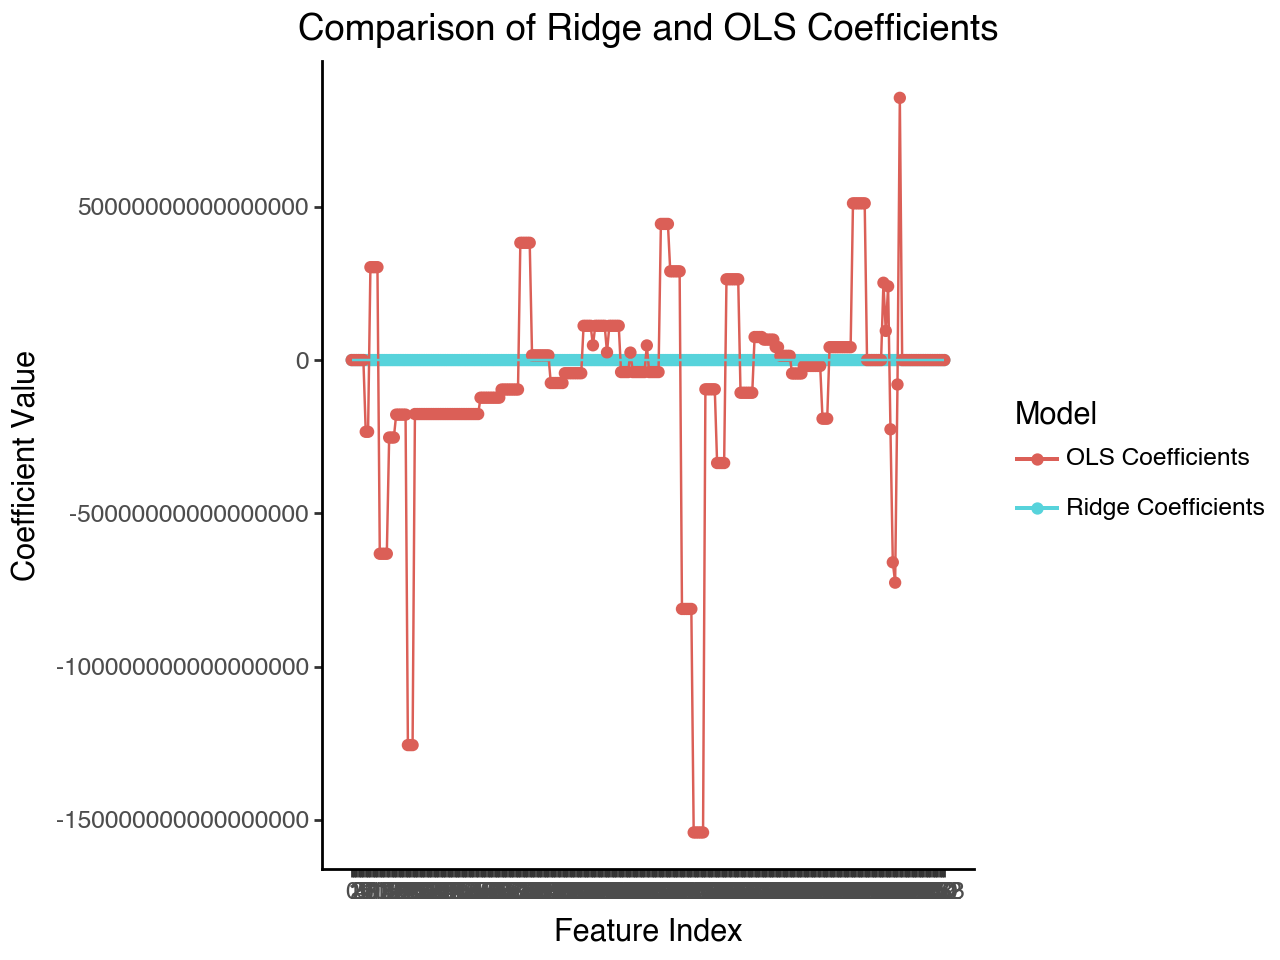

In [13]:
# Fit models on the whole dataset
lr_pipeline_ridge.fit(X, y)
lr_pipeline_ols.fit(X, y)

# Extract coefficients
ridge_coefficients = lr_pipeline_ridge.named_steps['ridge_regression'].coef_
ols_coefficients = lr_pipeline_ols.named_steps['linear_regression'].coef_

# Create DataFrame for plot
coeff_df = pd.DataFrame({
    'Feature Index': range(len(ridge_coefficients)),
    'Ridge Coefficients': ridge_coefficients,
    'OLS Coefficients': ols_coefficients
})

# Melt DataFrame for ggplot
coeff_melted = coeff_df.melt(id_vars='Feature Index', var_name='Model', value_name='Coefficient')

# Plot with ggplot style
(ggplot(coeff_melted, aes(x='Feature Index', y='Coefficient', color='Model'))
 + geom_point()
 + geom_line()
 + labs(title="Comparison of Ridge and OLS Coefficients",
        x="Feature Index", y="Coefficient Value")
 + theme_classic()
 + scale_x_continuous(breaks=range(len(ridge_coefficients)))
)

# Part 2 : Tuning

Using the same pipeline as previously, perform tuning on lamda.

You should always try lamda values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [54]:
from sklearn.model_selection import GridSearchCV

# Define the Ridge pipeline with placeholder alpha
lr_pipeline_ridge2 = Pipeline(steps=[('preprocessor', ct),
                                 ('ridge', Ridge())])

# Define parameter grid for alpha on a log scale
param_grid = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=lr_pipeline_ridge2, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X, y)

# Print best lambda and corresponding score
best_alpha = grid_search.best_params_['ridge__alpha']
best_score = -grid_search.best_score_
print(f'Best lambda (alpha): {best_alpha}')
print(f'Best Ridge MSE vs Original Ridge MSE: {best_score:,.2f} < {-ridge_cv_scores.mean():,.2f}')


Best lambda (alpha): 10
Best Ridge MSE vs Original Ridge MSE: 864,900,860.92 < 878,606,253.14


Here we see by using a lambda of 10, thus making the model simpler, we explain more of the data compared to the original ridge regression.

# Part 3 : LASSO

Create a LASSO pipeline, and tune lamda.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [74]:
# Define the LASSO pipeline with placeholder alpha
lr_pipeline_LASSO = Pipeline(steps=[('preprocessor', ct),
                                 ('lasso', Lasso(max_iter=10000))]) # Use max iter to avoid convergence errors

# Define parameter grid for alpha on a log scale
param_grid = {
    'lasso__alpha': [80, 100, 101, 150, 1000, 10000]
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=lr_pipeline_LASSO, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search.fit(X, y)

best_lasso_alpha = grid_search.best_params_['lasso__alpha']
best_lasso_score = -grid_search.best_score_
print(f'Best LASSO Alpha: {best_lasso_alpha}')
print(f'Best LASSO MSE vs Best Ridge MSE: {best_lasso_score:,.2f} < {best_score:,.2f}')

Best LASSO Alpha: 101
Best LASSO MSE vs Best Ridge MSE: 848,996,730.19 < 864,900,860.92


Here we see by using a lambda of 100 for LASSO regression we explain more of the data compared to the tuned ridge regression.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 29 rows containing missing values.


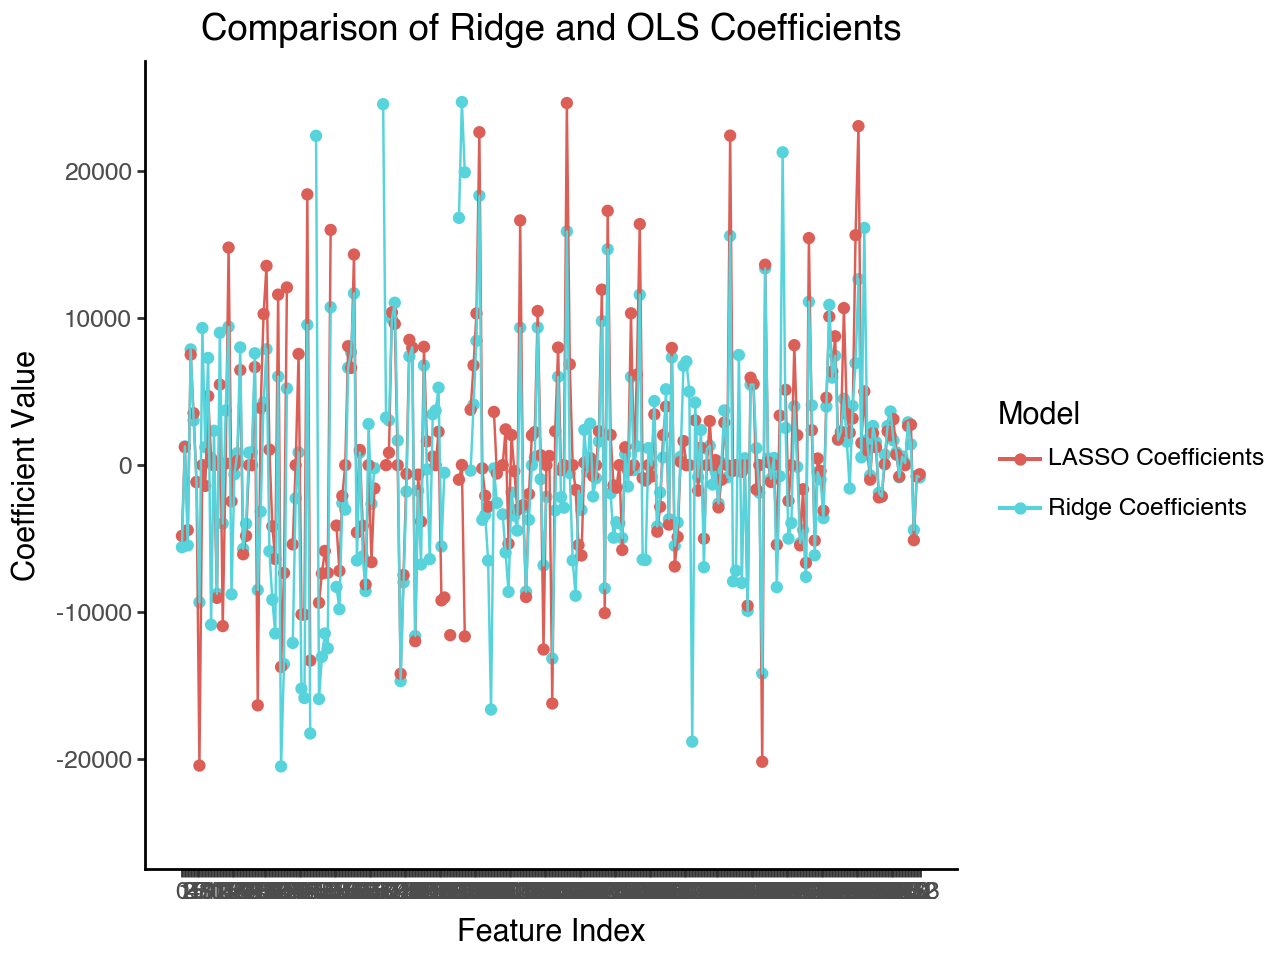

In [65]:
# Fit models on the whole dataset
lr_pipeline_ridge2.fit(X, y)
lr_pipeline_LASSO.fit(X, y)

# Extract coefficients
ridge_coefficients = lr_pipeline_ridge2.named_steps['ridge'].coef_
lASSO_coefficients = lr_pipeline_LASSO.named_steps['lasso'].coef_

# Create DataFrame for plot
coeff_df = pd.DataFrame({
    'Feature Index': range(len(ridge_coefficients)),
    'Ridge Coefficients': ridge_coefficients,
    'LASSO Coefficients': lASSO_coefficients
})

# Melt DataFrame for ggplot
coeff_melted = coeff_df.melt(id_vars='Feature Index', var_name='Model', value_name='Coefficient')

# Plot with ggplot style
(ggplot(coeff_melted, aes(x='Feature Index', y='Coefficient', color='Model'))
 + geom_point()
 + geom_line()
 + labs(title="Comparison of Ridge and OLS Coefficients",
        x="Feature Index", y="Coefficient Value")
 + theme_classic()
 + scale_x_continuous(breaks=range(len(ridge_coefficients)))
 + scale_y_continuous(limits=(-25000, 25000)))

Looking at the distribution of coefficients, we can see that the two models are similar but our LASSO model is slightly more compact.

# Part 4 : Elastic Net

Create an Elastic Net pipeline, and tune lamda and alpha.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [77]:
# Define the ElasticNet pipeline
lr_pipeline_elasticnet = Pipeline(steps=[('preprocessor', ct),
                                      ('elasticnet', ElasticNet(max_iter=5000))])

# Step 2: Define the parameter grid for alpha and l1_ratio
param_grid_en = {
    'elasticnet__alpha': [i for i in range(95, 110)],  # Regularization strength (lambda)
    'elasticnet__l1_ratio': [0.9, 0.95, 0.99, 1]  # Mix of LASSO and Ridge (alpha)
}

# Step 3: Perform GridSearchCV
grid_search_en = GridSearchCV(estimator=lr_pipeline_elasticnet, param_grid=param_grid_en, 
                              scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search_en.fit(X, y)

# Get the best parameters and score
best_en_alpha = grid_search_en.best_params_['elasticnet__alpha']
best_en_l1_ratio = grid_search_en.best_params_['elasticnet__l1_ratio']
best_en_score = -grid_search_en.best_score_

print(f'Best ElasticNet Alpha: {best_en_alpha}')
print(f'Best ElasticNet L1_ratio: {best_en_l1_ratio}')
print(f'Best ElasticNet MSE: {best_en_score:,.2f}')

Best ElasticNet Alpha: 101
Best ElasticNet L1_ratio: 1
Best ElasticNet MSE: 848,996,730.19


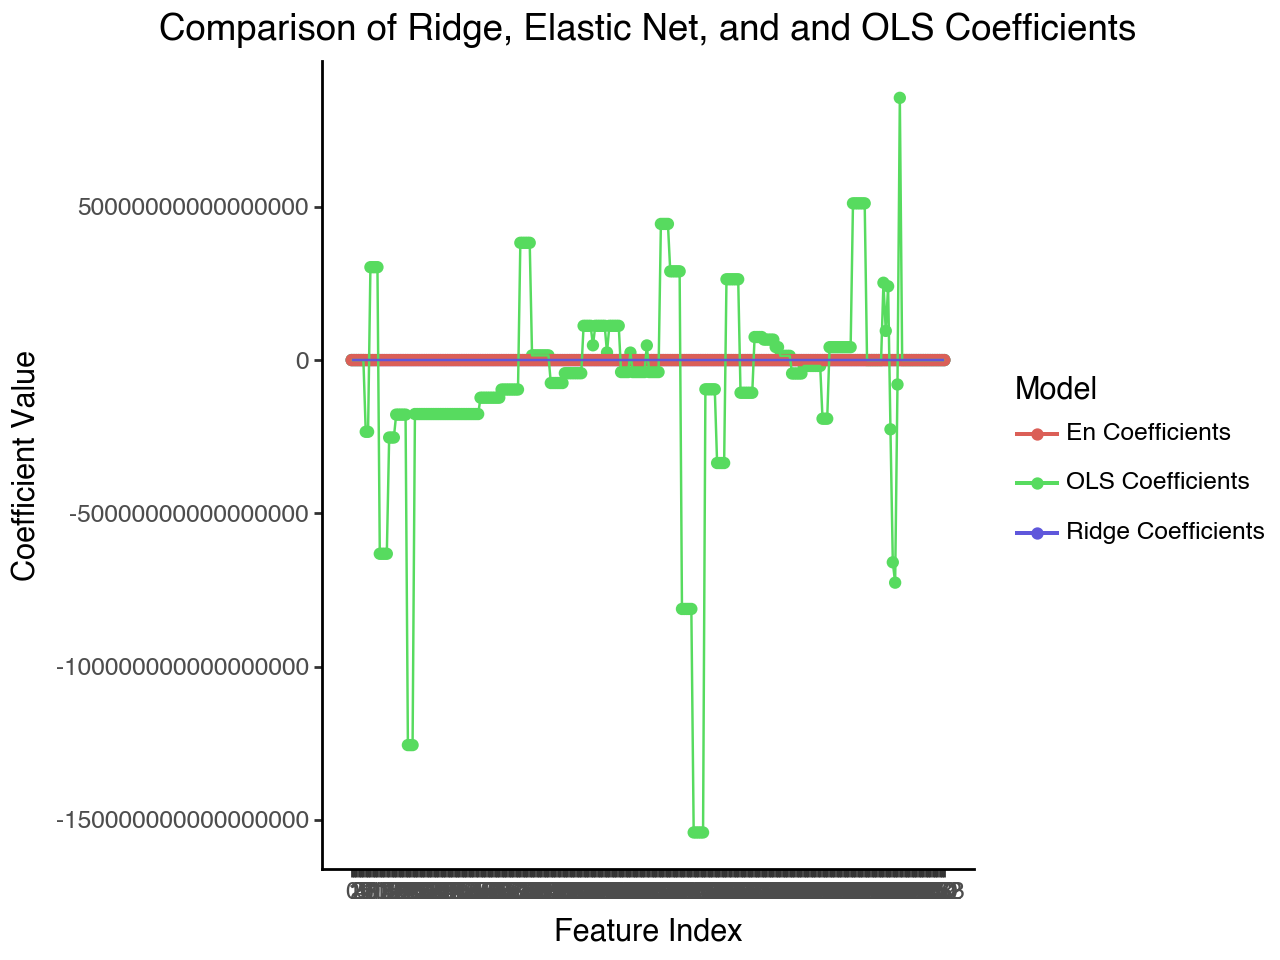

In [82]:
# Fit models on the whole dataset
lr_pipeline_elasticnet.fit(X, y)

# Extract coef
en_coefficients = lr_pipeline_elasticnet.named_steps['elasticnet'].coef_

# Create DataFrame for plot
coeff_df = pd.DataFrame({
    'Feature Index': range(len(ridge_coefficients)),
    'Ridge Coefficients': ridge_coefficients,
    'OLS Coefficients': ols_coefficients,
    'En Coefficients' : en_coefficients
})

# Melt DataFrame for ggplot
coeff_melted = coeff_df.melt(id_vars='Feature Index', var_name='Model', value_name='Coefficient')

# Plot with ggplot style
(ggplot(coeff_melted, aes(x='Feature Index', y='Coefficient', color='Model'))
 + geom_point()
 + geom_line()
 + labs(title="Comparison of Ridge, Elastic Net, and and OLS Coefficients",
        x="Feature Index", y="Coefficient Value")
 + theme_classic()
 + scale_x_continuous(breaks=range(len(ridge_coefficients)))
 #+ scale_y_continuous(limits=(-25000, 25000)))
)

I found that the Elastic Net pipeline uses an alpha of 1. This tells us that the model cares about the ridge reduction part of the elastic net procedure and none of the LASSO reduction. Thus we get the same coefficients as the previous section as shown by the overlapping red and purple lines.